## Get ProtBert-BFD embeddings from sequences

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
import re
import numpy as np
import pandas as pd
import os
import requests
import skimage.measure
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

2023-05-30 11:20:25.462029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load the model into the GPU if avilabile

In [4]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0 ) # device=0 for GPU, -1 for CPU

### Load sequences

In [48]:
SEQUENCE_PART = 'start' # 'start' or 'end', start is N terminus and it's the correct part
OUT_FILE = 'T3SE_clustered_embeddings_Nterm.csv'

In [40]:
def get_embedding(seq):
    seq = " ".join(re.sub(r"[UZOB]", "X", seq))
    embedding = fe(seq)
    features =  np.array(embedding[0][1:len(seq)+1])
    features = skimage.measure.block_reduce(features, (1024, 1), np.average)
    return features[0]

In [41]:
def write_sequences(fasta_file, label, out_file):
    fasta_sequences = SeqIO.parse(open(fasta_file),'fasta')
    
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        if SEQUENCE_PART == 'start':
            seq = sequence[:25]
        else:
            seq = sequence[-25:]
        
        out_file.write(name + ',' + label + ',' + seq + ',')
        embeddings = get_embedding(seq)
        out_file.write(','.join(str(e) for e in embeddings))
        out_file.write('\n')

In [42]:
from Bio import SeqIO

with open(OUT_FILE, 'w') as out_file:
    out_file.write('ID,Label,Sequence_part,' + ','.join(f"f{x}" for x in range(1024)) + '\n')
    write_sequences('raw_data/T3SE_positive_processed_with_cdhit_percentage_threshold_30.fasta', '1', out_file)
    write_sequences('raw_data/T3SE_negative_processed_with_cdhit_percentage_threshold_30.fasta', '0', out_file)

/home/jovyan/my-conda-envs/transformers/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


## Draw t-sne plots

In [49]:
embedding_df = pd.read_csv(OUT_FILE)
embedding_df

,ID,Label,Sequence_part,f0,f1,f2,f3,f4,f5,f6,...,f1014,f1015,f1016,f1017,f1018,f1019,f1020,f1021,f1022,f1023
0,103.506,1,MQIQTHTGGLQAVAQHSDAAAGVGK,0.000751,-0.000941,-0.000667,0.000761,0.000501,0.000295,0.000470,...,-0.001318,-0.000902,0.000286,0.000623,0.001142,-0.001135,0.000371,-0.000021,-0.000687,0.000711
1,17137.1741,1,MKITSPDIDVSRHQQTTPDATPPAT,0.000641,-0.001545,-0.000636,-0.001689,0.001306,0.000225,0.000582,...,0.001545,-0.000417,-0.000865,-0.001470,0.003024,-0.000396,0.000003,-0.000615,0.002813,0.000202
2,18299.678,1,MMMTITSISQSQHTSGTSISAPISP,0.000183,-0.001060,-0.000334,-0.001492,0.000431,-0.001114,0.000533,...,0.001135,-0.000576,0.000361,0.000995,0.000552,-0.000367,-0.000053,0.000486,0.000850,0.002080
3,26797.2799,1,MEHISSLRLSQDAVNLEPSPIQGKQ,0.000551,-0.001140,0.000920,-0.000205,0.000288,-0.000202,0.001034,...,-0.000331,-0.000963,-0.000161,0.000571,0.001525,-0.001631,-0.000440,0.000204,-0.000953,0.000598
4,ELU40828.1,1,MLASFAAAFLLGVASTLALPAPIPR,0.000556,-0.001382,0.000414,0.001474,-0.000785,0.000108,0.000231,...,-0.000870,0.000024,-0.000576,-0.000723,0.001623,-0.000509,-0.000645,-0.000680,-0.000151,0.000362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,sp|Q46995.1|CCDA2_ECOLX,0,MKQRITVAGDSDNYQLLKAYDVNIS,-0.000569,0.000074,0.000152,0.000560,0.000500,0.000052,-0.000231,...,-0.000863,-0.001379,-0.000170,0.000576,0.002872,-0.001399,0.000104,-0.000913,-0.001449,0.000438
3763,sp|Q47282.1|T1ME_ECOLX,0,MSISSVIKSLQDIMRKDAGVDGDAQ,0.000022,-0.000902,0.000819,0.000968,0.000069,-0.000062,0.000551,...,-0.001294,-0.000659,0.000173,0.000762,0.000628,-0.001806,0.000805,-0.000500,-0.000096,0.000757
3764,sp|Q47503.1|IMMK_ECOLX,0,MHLKYYLHNLPESLIPWILILIFND,-0.000143,0.000077,0.000614,0.000922,-0.000884,0.000742,0.000016,...,0.000263,-0.000835,-0.001828,-0.000552,0.002601,-0.001337,-0.001278,-0.000648,-0.000557,-0.000075
3765,sp|Q51773.1|MERD_PSEFL,0,MSAYTVSRLALDAGVSVHIVRDYLL,0.000023,-0.000652,0.000465,0.000382,-0.000007,-0.000811,-0.000632,...,0.000679,-0.000292,-0.000980,0.000275,0.000459,-0.000654,-0.000431,-0.001474,-0.000643,0.000710


In [44]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(np.array(embedding_df.drop(columns=['ID', 'Label', 'Sequence_part']).values.tolist()))
df = pd.DataFrame()
df["y"] = embedding_df['Label']
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3767 samples in 0.002s...
[t-SNE] Computed neighbors for 3767 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3767
[t-SNE] Computed conditional probabilities for sample 2000 / 3767
[t-SNE] Computed conditional probabilities for sample 3000 / 3767
[t-SNE] Computed conditional probabilities for sample 3767 / 3767
[t-SNE] Mean sigma: 0.009775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.723969
[t-SNE] KL divergence after 1000 iterations: 1.967380


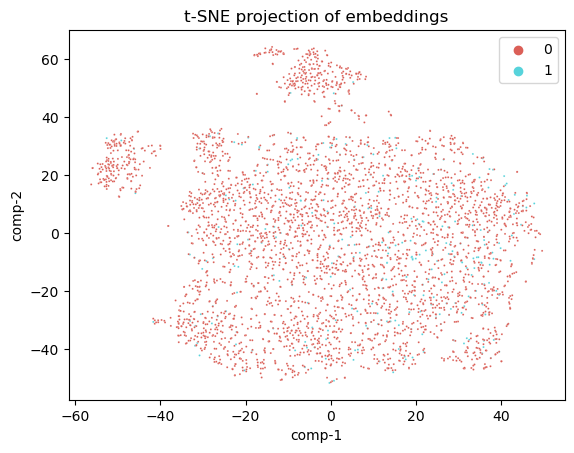

In [45]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df, s=2).set(title="t-SNE projection of embeddings")
plt.savefig("tsne_Cterm.png", dpi=300)

## Train - test split

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(embedding_df, test_size=0.2, random_state=42)
train.to_csv('T3SE_clustered_embeddings_Nterm_train.csv', index=False)
test.to_csv('T3SE_clustered_embeddings_Nterm_test.csv', index=False)

In [51]:
train['Label'].value_counts()

0    2784
1     229
Name: Label, dtype: int64

In [52]:
test['Label'].value_counts()

0    679
1     75
Name: Label, dtype: int64